# Análisis de series de tiempo de delitos en la Ciudad de México

El siguiente análisis tiene por objetivo conocer el comportamiento a través del tiempo de los delitos denunciados ante la Secretaría de Seguridad Ciudadana de la Ciudad de México. Los datos crudos se encuentran disponibles en la página oficial de [Datos Abiertos de la Ciudad de México.](https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-cdmx/export/)

In [136]:
#install.packages(c("forecast","plotly","ggrepel"))
options(repr.plot.width=22, repr.plot.height=8)

# Librerías

In [80]:
library(dplyr)
library(lubridate)
library(magrittr)
library(readr)
library(forecast)
library(stringr)
library(plotly)

# Carga de Datos

Con el objetivo de subir un gran volumen de datos al repositorio de GitHub, los datos fueron filtrados y guardados en formato .rds. El filtro permite conservar únicamente los delitos identificados dentro del perímetro de la Ciudad de México, así como las columnas que se muestran a continuación:

In [8]:
data <- readRDS("data/datos_delitos.rds")
head(data)

fecha_hechos        categoria_delito                                    
1 2017-11-01 16:40:00 ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA
2 2018-05-16 16:00:00 ROBO A REPARTIDOR CON Y SIN VIOLENCIA               
3 2018-05-21 20:40:00 DELITO DE BAJO IMPACTO                              
4 2018-05-22 06:20:00 DELITO DE BAJO IMPACTO                              
5 2017-11-01 17:15:00 DELITO DE BAJO IMPACTO                              
6 2017-11-01 09:00:00 DELITO DE BAJO IMPACTO                              
  alcaldia_hechos longitud  latitud 
1 IZTACALCO       -99.10607 19.39540
2 IZTAPALAPA      -99.04279 19.31914
3 IZTACALCO       -99.11156 19.38659
4 BENITO JUAREZ   -99.17710 19.37958
5 CUAUHTEMOC      -99.13245 19.43179
6 CUAUHTEMOC      -99.16829 19.40599

# Manipulación de Datos

Para realizar un ejemplo de series de tiempo con los datos, se conservan los delitos identificados antes del año 2019. Posteriormente se realiza un conteo de delitos cometidos de manera diaria.

In [9]:
data %<>% mutate(fecha = date(fecha_hechos), mes = month(fecha_hechos, label = T)) %>% filter(fecha < '2019-01-01')

In [10]:
head(data)

fecha_hechos        categoria_delito                                    
1 2017-11-01 16:40:00 ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA
2 2018-05-16 16:00:00 ROBO A REPARTIDOR CON Y SIN VIOLENCIA               
3 2018-05-21 20:40:00 DELITO DE BAJO IMPACTO                              
4 2018-05-22 06:20:00 DELITO DE BAJO IMPACTO                              
5 2017-11-01 17:15:00 DELITO DE BAJO IMPACTO                              
6 2017-11-01 09:00:00 DELITO DE BAJO IMPACTO                              
  alcaldia_hechos longitud  latitud  fecha      mes
1 IZTACALCO       -99.10607 19.39540 2017-11-01 Nov
2 IZTAPALAPA      -99.04279 19.31914 2018-05-16 May
3 IZTACALCO       -99.11156 19.38659 2018-05-21 May
4 BENITO JUAREZ   -99.17710 19.37958 2018-05-22 May
5 CUAUHTEMOC      -99.13245 19.43179 2017-11-01 Nov
6 CUAUHTEMOC      -99.16829 19.40599 2017-11-01 Nov

In [14]:
delitos <- data %>% group_by(fecha) %>% tally() %>% tibble %>% mutate(dia_semana = wday(fecha, label = T, abbr = F))
sample_n(delitos, 10)

fecha      n   dia_semana
1  2017-08-28 629 Monday    
2  2018-08-11 570 Saturday  
3  2018-11-14 564 Wednesday 
4  2017-02-02 570 Thursday  
5  2018-02-14 694 Wednesday 
6  2018-08-27 670 Monday    
7  2018-03-24 571 Saturday  
8  2017-09-10 531 Sunday    
9  2017-05-21 434 Sunday    
10 2018-09-17 677 Monday

In [15]:
summary(delitos)

     fecha                  n             dia_semana 
 Min.   :2017-01-01   Min.   :311.0   Sunday   :105  
 1st Qu.:2017-07-02   1st Qu.:565.2   Monday   :105  
 Median :2017-12-31   Median :635.5   Tuesday  :104  
 Mean   :2017-12-31   Mean   :623.1   Wednesday:104  
 3rd Qu.:2018-07-01   3rd Qu.:690.0   Thursday :104  
 Max.   :2018-12-31   Max.   :885.0   Friday   :104  
                                      Saturday :104  

# Gráfico de serie de tiempo

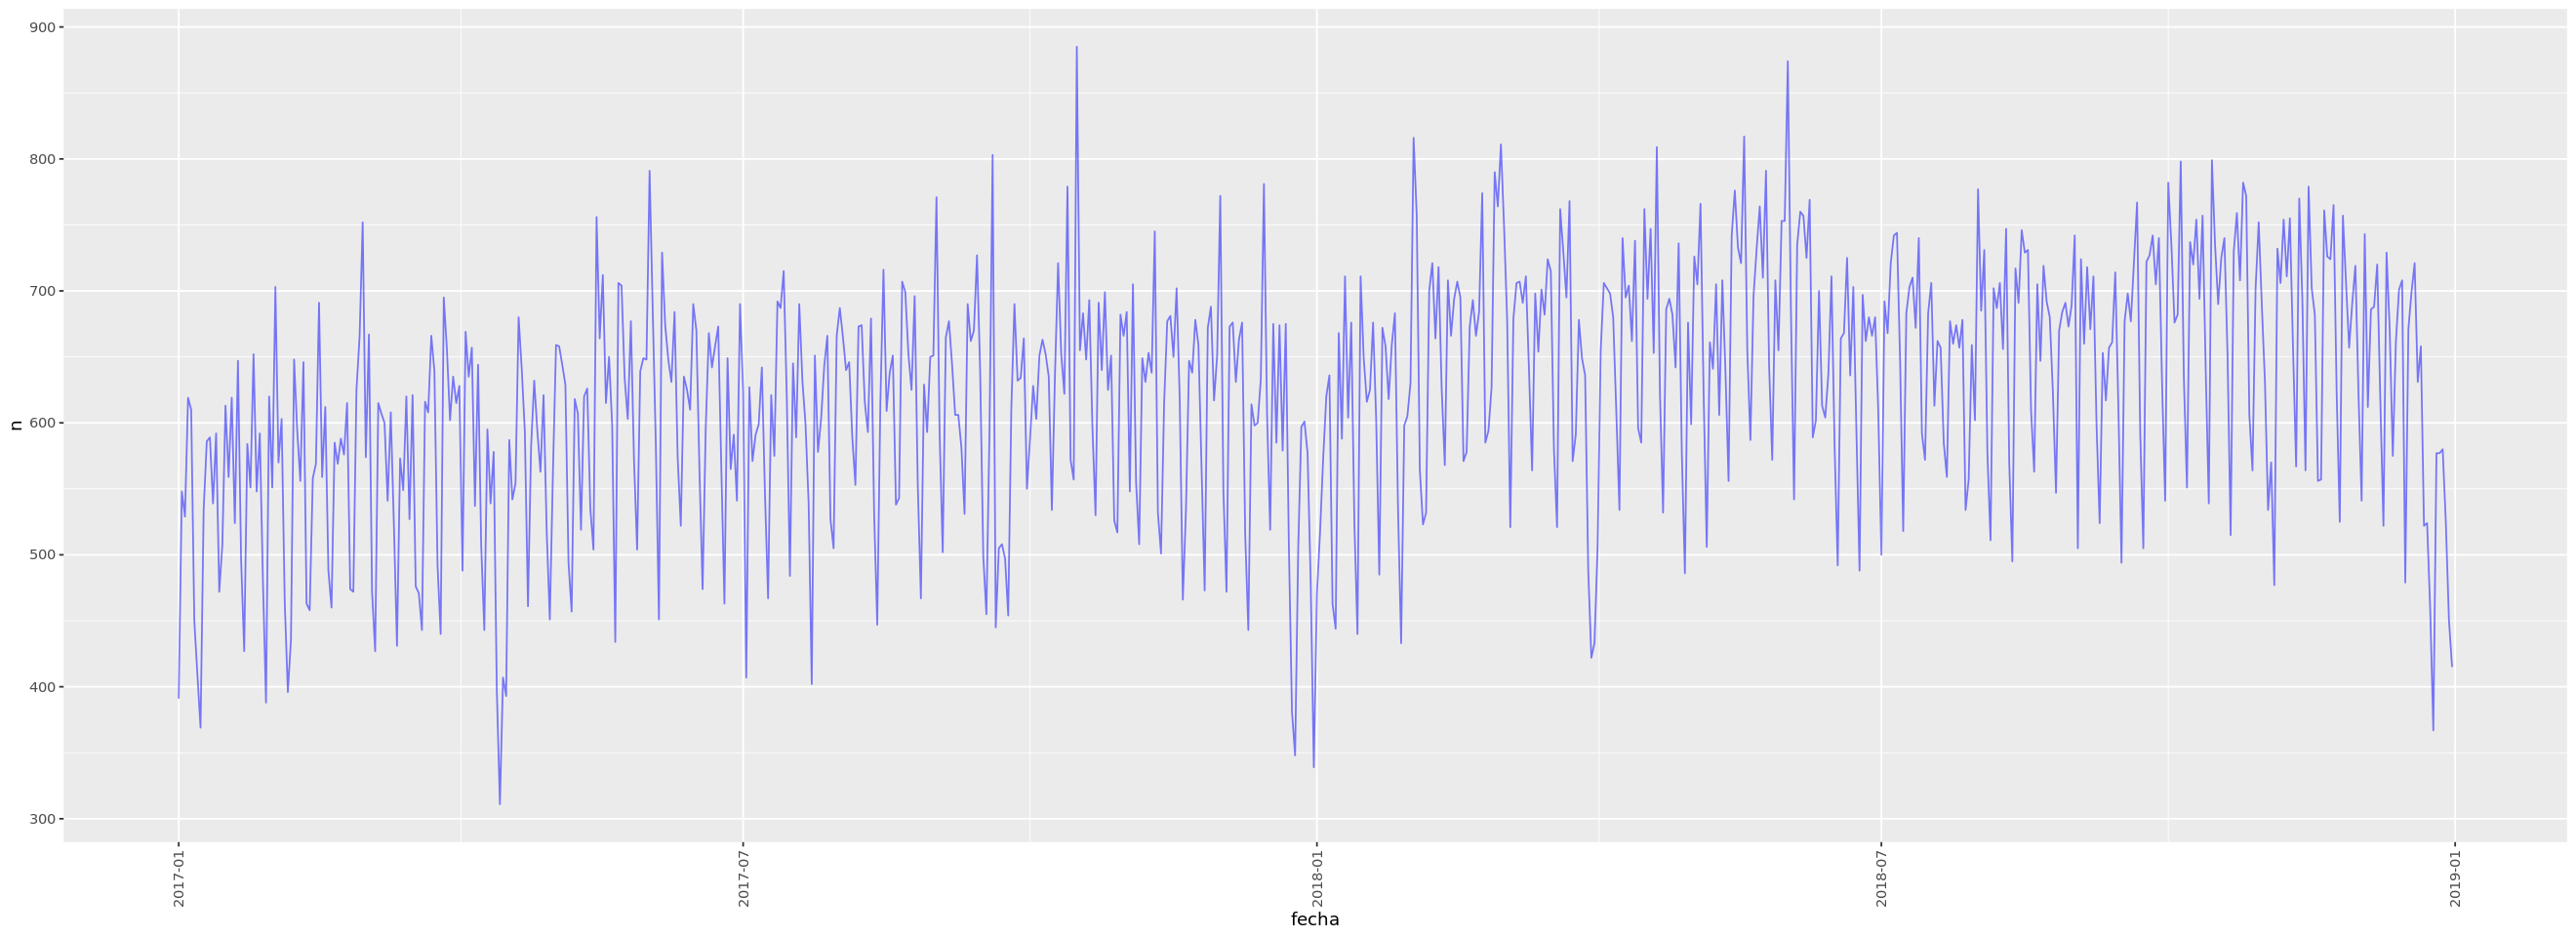

In [137]:
plot <- ggplot(delitos, aes(x = fecha, y = n, label = dia_semana)) + 
    geom_line(color = "blue", 
              alpha = 0.5, position = position_dodge(0.8)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

#ggplotly(plot)
plot

# Modelo estacional

Para predecir el número de delitos en la segunda mitad del año 2018, se analizan los datos entre el primero de enero del 2017 y la primera mitad del año 2018. Posteriormente, se ajustan distintos modelos para identificar cual de ellos ajusta mejor a los datos. La medida de error usada es la raíz de error cuadrático medio **RMSE**.

In [19]:
first_day <- pull(head(delitos,1), fecha)

y <- msts(delitos[delitos$fecha < '2018-07-01',]$n, seasonal.periods = c(7), start = c(2017, 1))
n = 184

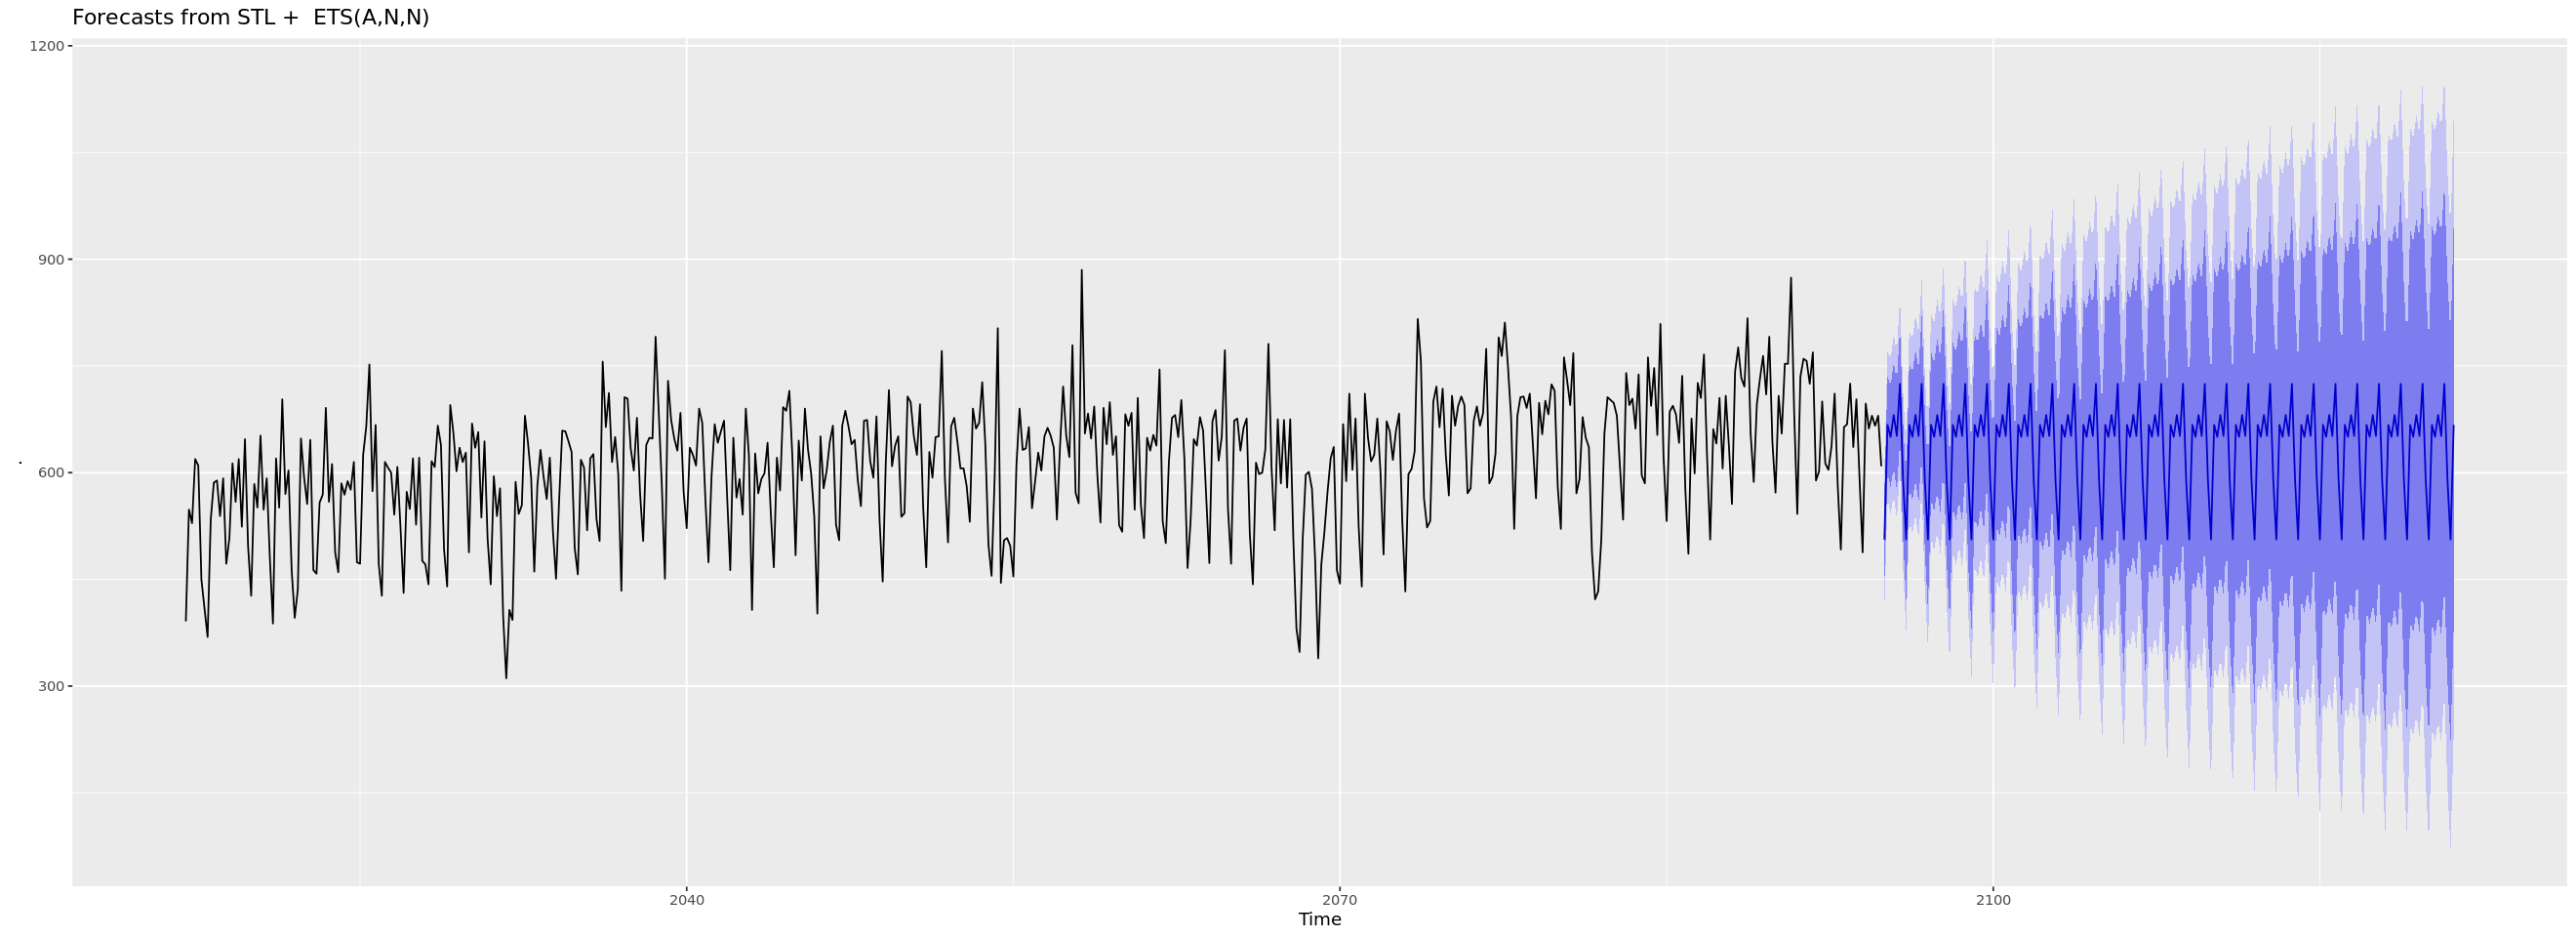

In [20]:
mod1 <- y %>% stlf(h = n, method = "ets") 
mod1 %>% autoplot()

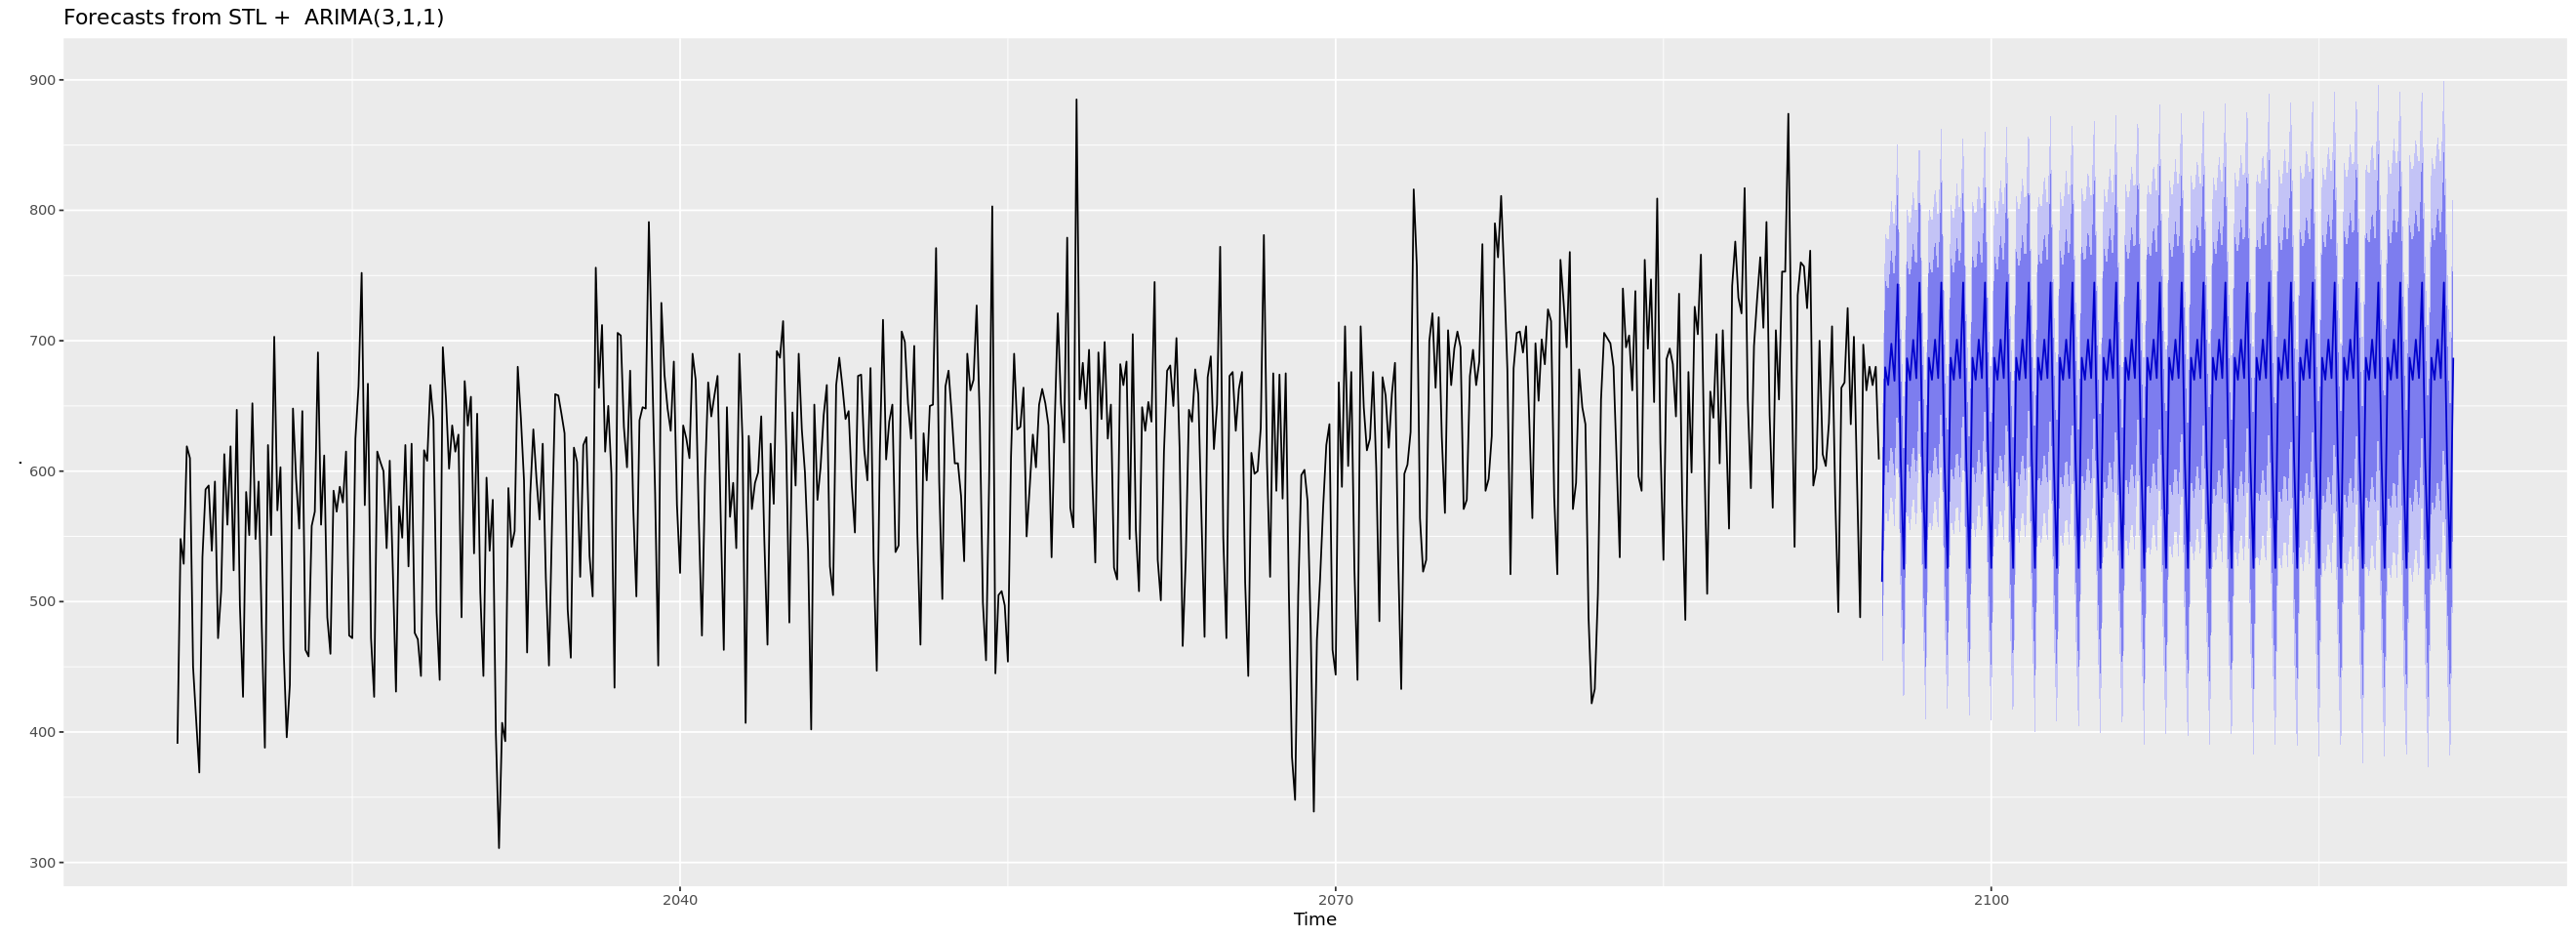

In [21]:
mod2 <- y %>% stlf(h = n, method = "arima") 
mod2 %>% autoplot()

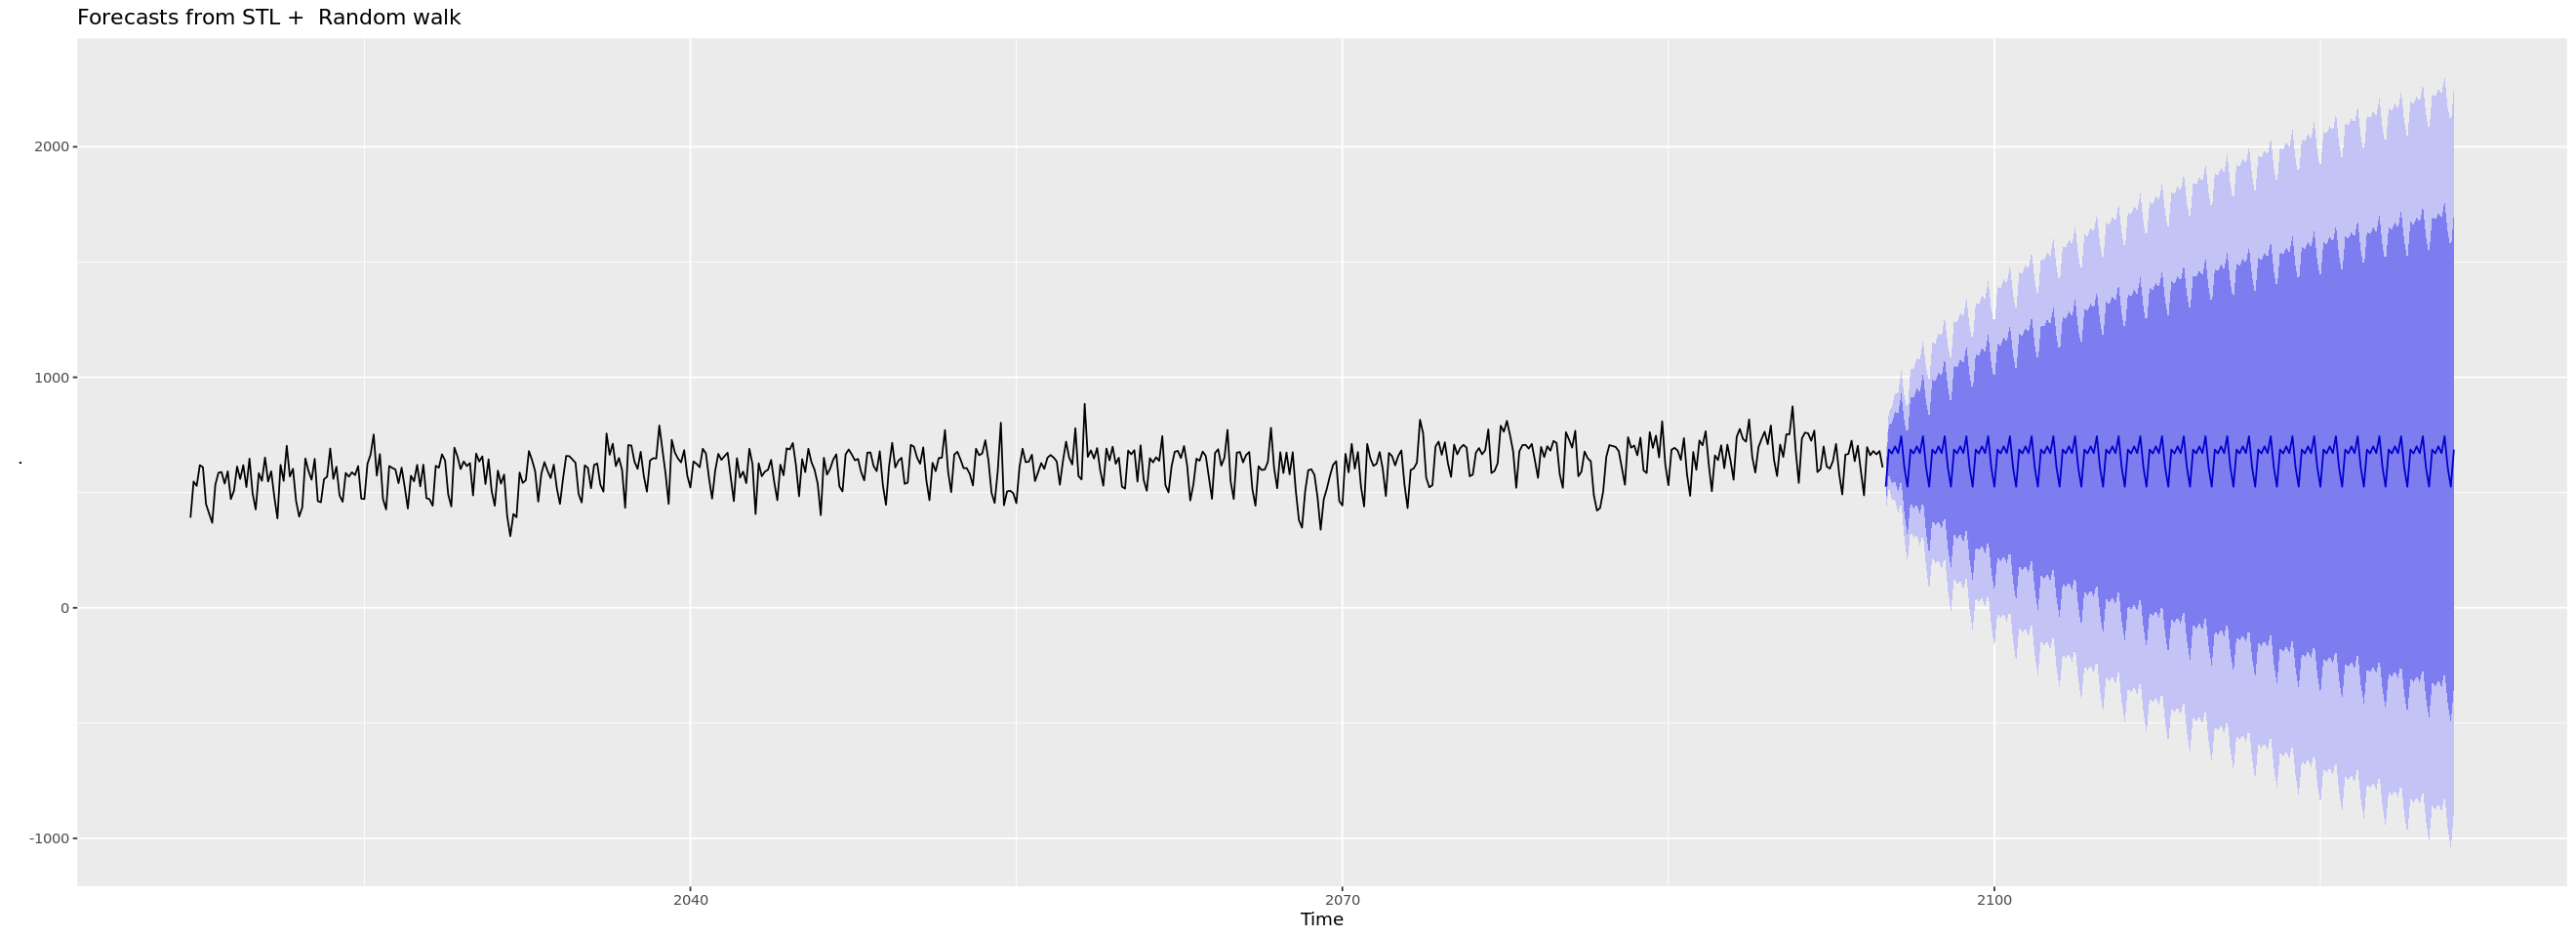

In [22]:
mod3 <- y %>% stlf(h = n, method = "naive") 
mod3 %>% autoplot()

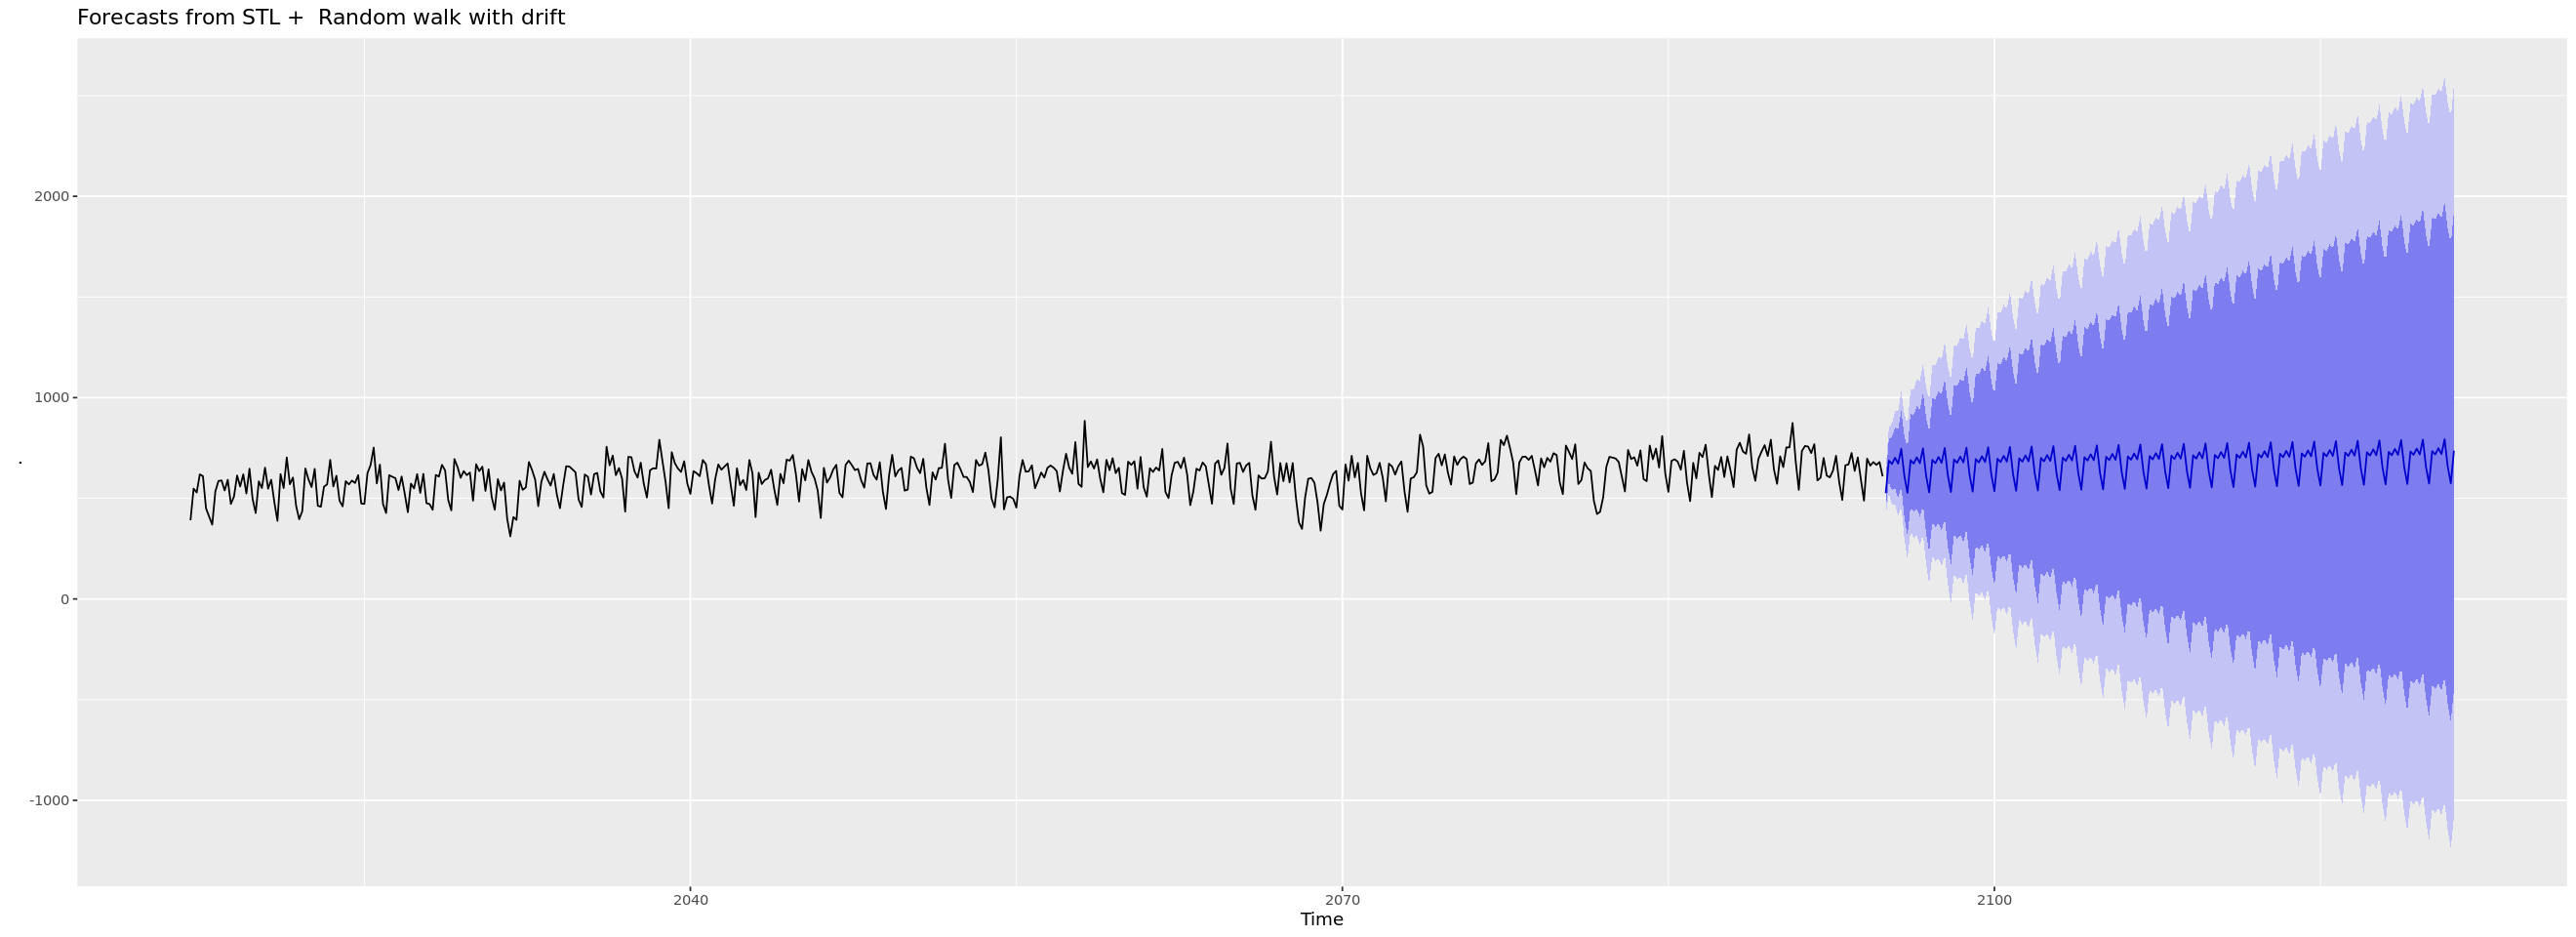

In [23]:
mod4 <- y %>% stlf(h = n, method = "rwdrift") 
mod4 %>% autoplot()

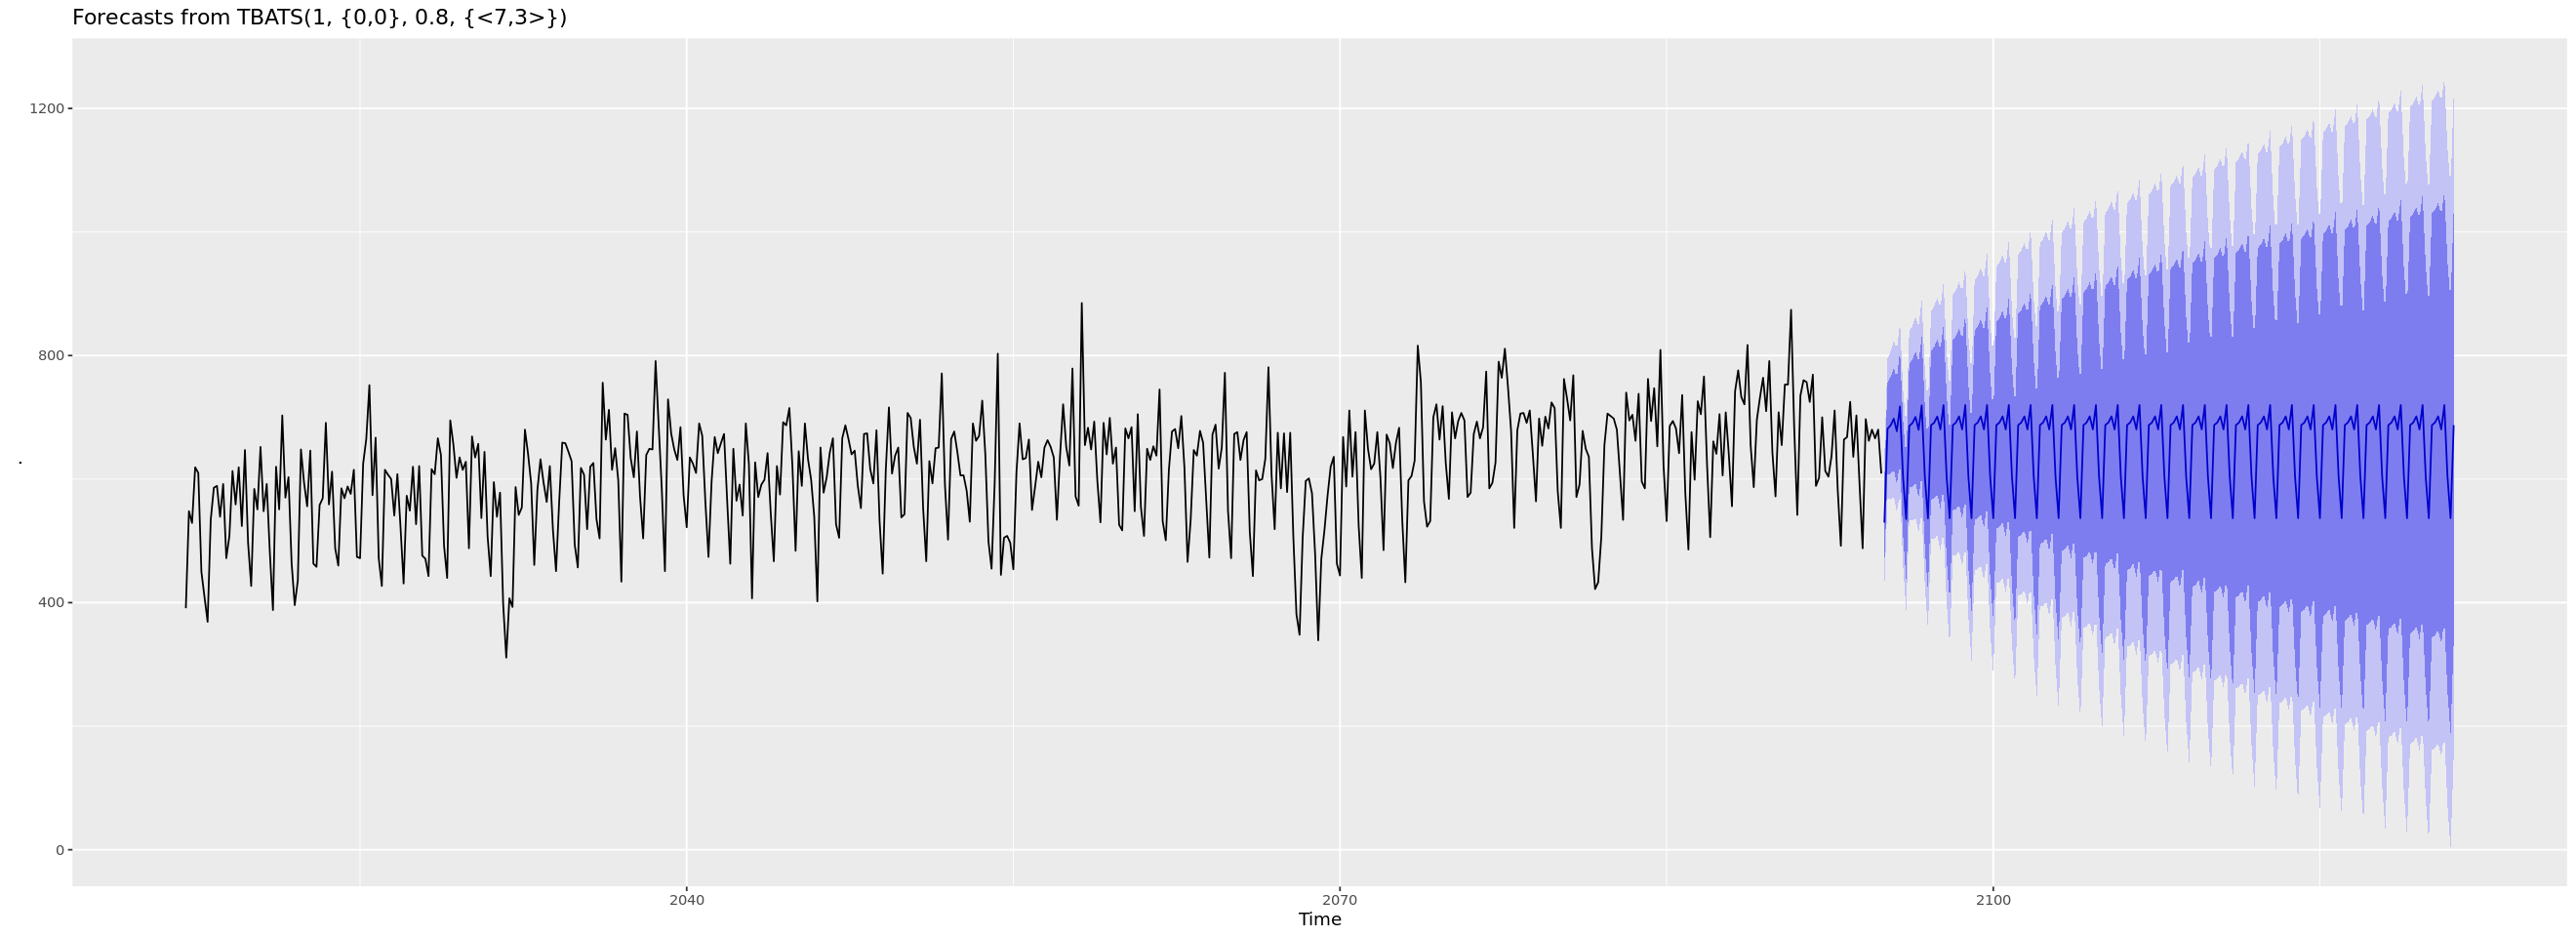

In [24]:
fit5 <- y %>% tbats()
mod5 <- forecast(fit5, h = n, lambda = "auto")
mod5 %>% autoplot()

A continuación, se comparan las distintas medidas de error entre los diferentes modelos. Como se mencionó anteriormente, el error usado para determinar el mejor modelo será el RMSE.

In [25]:
resultados <- rbind.data.frame(accuracy(mod1),accuracy(mod2),accuracy(mod3),accuracy(mod4),accuracy(mod5)) %>% round(3) 
row.names(resultados) <- c("ets","arima","naive","rwdrift","auto")
resultados

ME    RMSE   MAE    MPE    MAPE  MASE  ACF1  
ets     0.716 50.444 37.419 -0.524 6.365 0.661  0.070
arima   2.946 49.462 35.953 -0.196 6.102 0.635 -0.007
naive   0.271 59.127 44.731 -0.457 7.555 0.791 -0.424
rwdrift 0.000 59.127 44.740 -0.502 7.558 0.791 -0.424
auto    3.865 54.284 38.566 -0.159 6.584 0.682  0.007

el modelo ARIMA es seleccionado como el modelo que mejor ajusta a los datos. El RMSE asociado es de 49.4, sin embargo, dicho error corresponde al ajuste realizado y a los datos observados. Para obtener un RMSE predictivo, es necesario realizar el cálculo del error entre las predicciones realizadas y los datos observados que no formaron parte del ajuste del modelo. A continuación se crea la tabla que permite comparar ambas columnas.

Adicionalmente, se agregan las columnas con el límite inferior y superior del intervalo de confianza al 95%.

In [50]:
comp = data.frame(fecha = date('2018-07-01') + 0:(n-1), 
                  real = delitos[delitos$fecha %in% (date('2018-07-01') + 0:(n-1)),]$n,
                  lower = round(mod2$lower[1:n,2]),
                  prediction = round(mod2$mean[1:n]),
                  upper = round(mod2$upper[1:n,2]))
comp %<>% mutate(sq_diff = (prediction - real)^2)

head(comp,10)

fecha      real lower prediction upper sq_diff
1  2018-07-01 500  418   515        613    225   
2  2018-07-02 692  576   680        783    144   
3  2018-07-03 668  558   666        774      4   
4  2018-07-04 721  587   698        808    529   
5  2018-07-05 742  557   669        781   5329   
6  2018-07-06 744  630   743        856      1   
7  2018-07-07 647  494   608        722   1521   
8  2018-07-08 518  411   525        640     49   
9  2018-07-09 683  572   687        801     16   
10 2018-07-10 703  554   670        785   1089

El **RMSE** calculado es: 61

In [51]:
comp$sq_diff %>% mean() %>% sqrt() %>% round()

[1] 61

# Visualización de predicción de delitos en la Ciudad de México

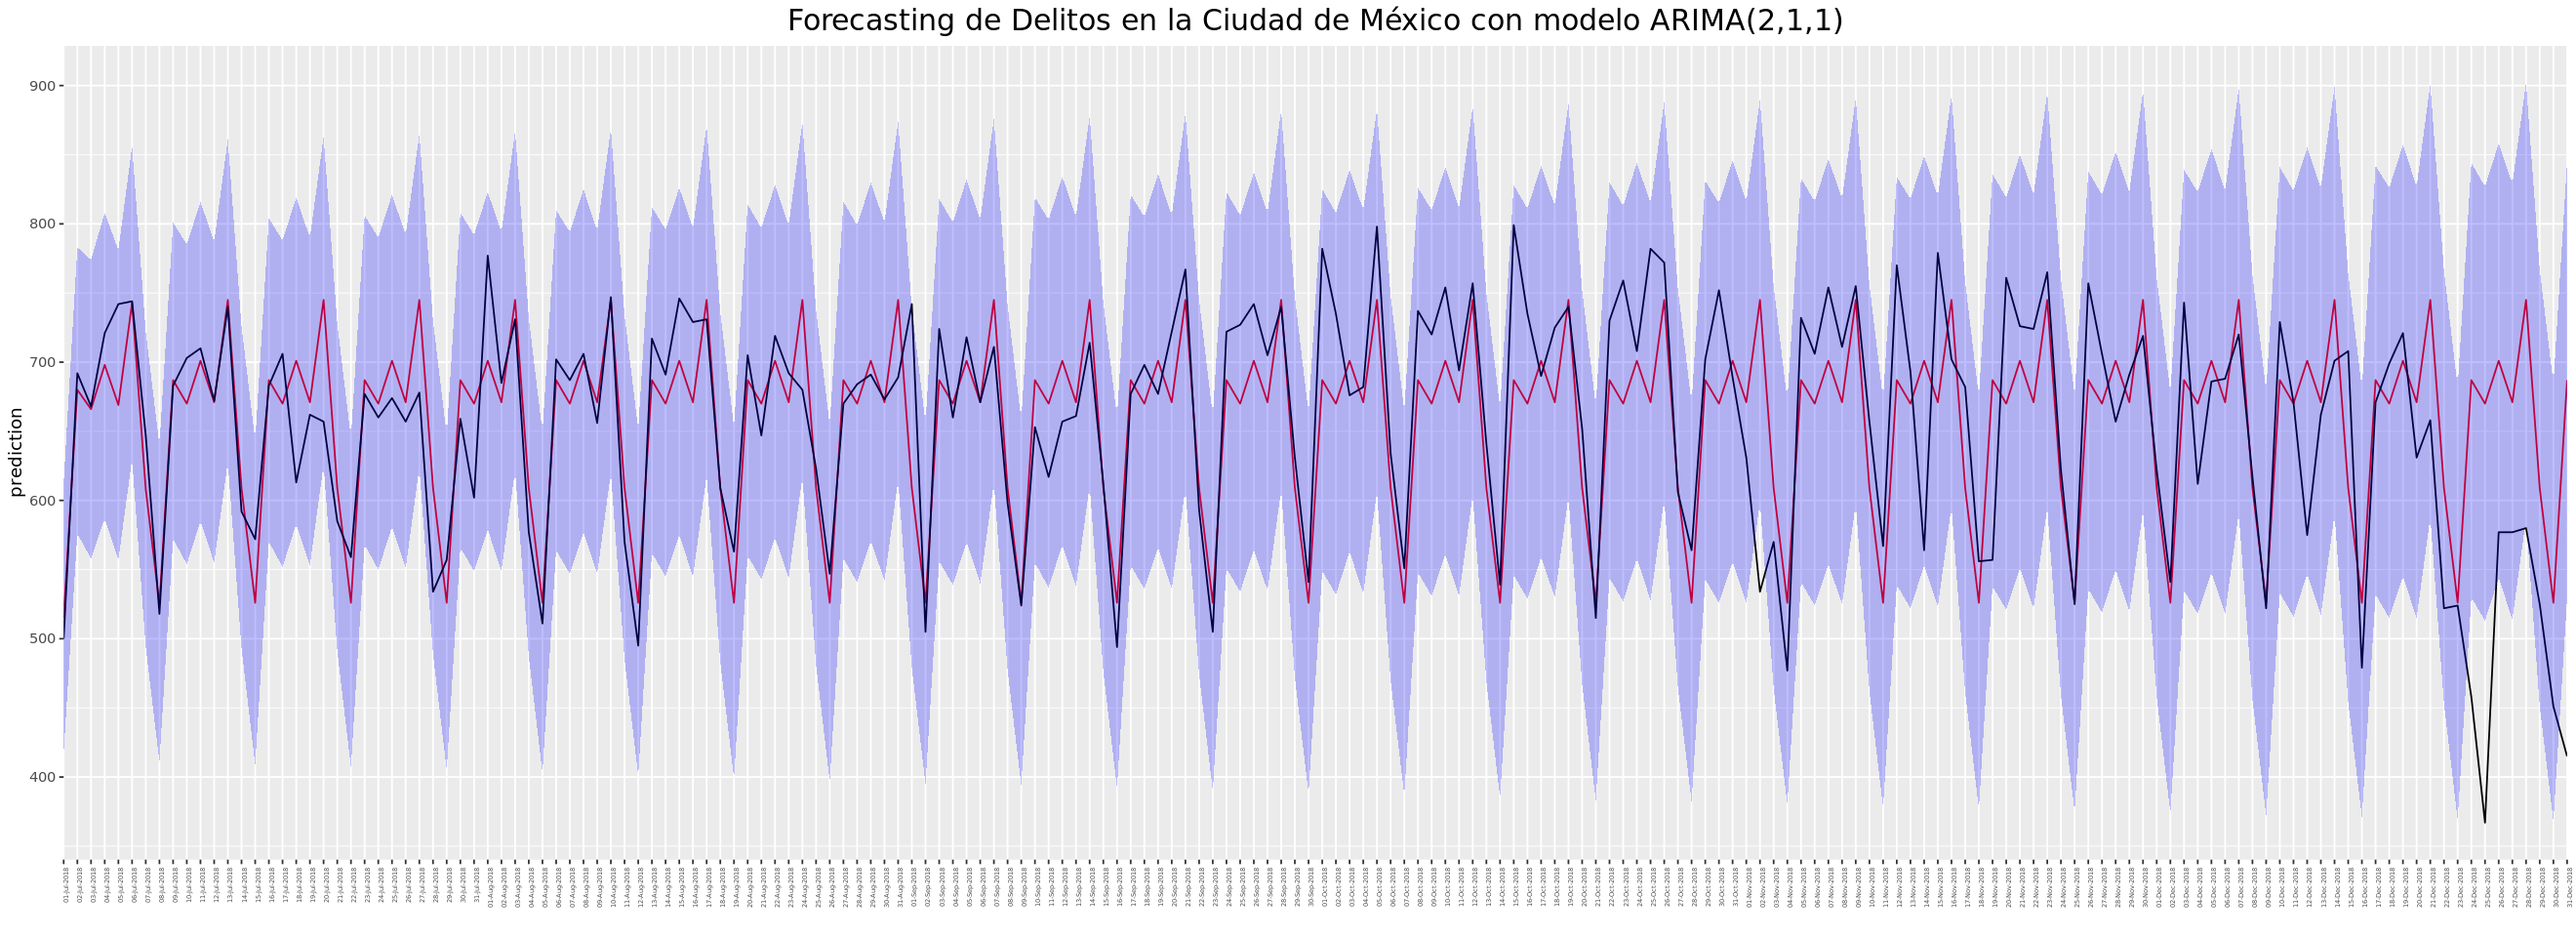

In [138]:
forecast_plot <- ggplot(data = comp, aes(x = fecha)) +
    geom_line(aes(y = prediction), col = "red") +
    geom_line(aes(y = real), col = "black") +
    geom_ribbon(aes(ymin = lower, ymax = upper),
                alpha = 0.25, fill = "blue") +
    scale_x_date(name ='', breaks = '1 day', minor_breaks = '1 day', 
                 labels = scales::date_format("%d-%b-%Y"), expand = c(0,0)) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 4), plot.title = element_text(size=18, hjust = 0.5)) +
    ggtitle("Forecasting de Delitos en la Ciudad de México con modelo ARIMA(2,1,1)")

#ggplotly(forecast_plot)
forecast_plot

A continuación se calcula la proporción en la que el intervalo de confianza cubre al número real de delitos reportados.

In [31]:
conf = comp %>% 
mutate(flag = ifelse(and(real > lower, real < upper),1,0)) 

conf %>% summarise(confidence = mean(flag))

confidence
1 0.9673913

Se observa que en su mayoría, los días que el intervalo no cubre al valor real de delitos es porque se trata de un día festivo. En esos días, la siniestralidad es significativamente menor a la estimada bajo condiciones normales.

In [32]:
conf %>% filter(flag == 0)

fecha      real lower prediction upper sq_diff flag
1 2018-09-01 742  479   609        739   17689   0   
2 2018-11-02 534  599   745        890   44521   0   
3 2018-12-24 458  530   687        844   52441   0   
4 2018-12-25 367  513   670        827   91809   0   
5 2018-12-28 580  587   745        902   27225   0   
6 2018-12-31 415  529   687        845   73984   0

# Predicciones diarias

A continuación, se muestra una tabla con las predicciones diarias de la segunda mitad del año 2018.

In [402]:
comp

fecha      real lower prediction upper sq_diff
1   2018-07-01 500  418   515        613    225   
2   2018-07-02 692  576   680        783    144   
3   2018-07-03 668  558   666        774      4   
4   2018-07-04 721  587   698        808    529   
5   2018-07-05 742  557   669        781   5329   
6   2018-07-06 744  630   743        856      1   
7   2018-07-07 647  494   608        722   1521   
8   2018-07-08 518  411   525        640     49   
9   2018-07-09 683  572   687        801     16   
10  2018-07-10 703  554   670        785   1089   
11  2018-07-11 710  585   701        816     81   
12  2018-07-12 672  555   671        787      1   
13  2018-07-13 740  628   745        861     25   
14  2018-07-14 592  493   609        726    289   
15  2018-07-15 572  409   526        643   2116   
16  2018-07-16 683  570   687        804     16   
17  2018-07-17 706  552   670        788   1296   
18  2018-07-18 613  583   701        819   7744   
19  2018-07-19 662  553   671        790     81   
20  2018-07-20 657  626   745        863   7744   
21  2018-07-21 585  491   609        728    576   
22  2018-07-22 559  407   526        645   1089   
23  2018-07-23 677  568   687        806    100   
24  2018-07-24 660  550   670        790    100   
25  2018-07-25 674  581   701        821    729   
26  2018-07-26 657  551   671        792    196   
27  2018-07-27 678  624   745        865   4489   
28  2018-07-28 534  489   609        730   5625   
29  2018-07-29 557  405   526        647    961   
30  2018-07-30 659  566   687        808    784   
⋮   ⋮          ⋮    ⋮     ⋮          ⋮     ⋮      
155 2018-12-02 541  374   526        678     225  
156 2018-12-03 743  535   687        839    3136  
157 2018-12-04 612  518   670        823    3364  
158 2018-12-05 686  548   701        854     225  
159 2018-12-06 688  518   671        824     289  
160 2018-12-07 720  591   745        898     625  
161 2018-12-08 617  456   609        763      64  
162 2018-12-09 522  372   526        679      16  
163 2018-12-10 729  533   687        841    1764  
164 2018-12-11 671  516   670        824       1  
165 2018-12-12 575  547   701        855   15876  
166 2018-12-13 662  517   671        826      81  
167 2018-12-14 701  590   745        899    1936  
168 2018-12-15 708  454   609        764    9801  
169 2018-12-16 479  371   526        681    2209  
170 2018-12-17 671  532   687        842     256  
171 2018-12-18 699  515   670        826     841  
172 2018-12-19 721  545   701        857     400  
173 2018-12-20 631  515   671        827    1600  
174 2018-12-21 658  588   745        901    7569  
175 2018-12-22 522  453   609        766    7569  
176 2018-12-23 524  369   526        682       4  
177 2018-12-24 458  530   687        844   52441  
178 2018-12-25 367  513   670        827   91809  
179 2018-12-26 577  544   701        858   15376  
180 2018-12-27 577  514   671        829    8836  
181 2018-12-28 580  587   745        902   27225  
182 2018-12-29 525  451   609        767    7056  
183 2018-12-30 451  368   526        684    5625  
184 2018-12-31 415  529   687        845   73984

# Predicciones desagregadas por alcaldía

Vale la pena estudiar la diferencia entre alcaldías del número de delitos que se reportan en cada una. A continuación se muestra la tabla con la que se realizan los conteos agregados, así como una gráfica con la serie temporal asociada a cada alcaldía

In [33]:
delitos_mun <- data %>% group_by(alcaldia_hechos, fecha) %>% tally() %>% tibble %>% mutate(dia_semana = wday(fecha, label = T, abbr = F))
sample_n(delitos_mun, 10)

alcaldia_hechos        fecha      n   dia_semana
1  TLAHUAC                2017-08-26   8 Saturday  
2  MILPA ALTA             2017-02-19   4 Sunday    
3  CUAJIMALPA DE MORELOS  2017-03-02   4 Thursday  
4  LA MAGDALENA CONTRERAS 2018-10-14  16 Sunday    
5  CUAUHTEMOC             2017-08-22 101 Tuesday   
6  IZTAPALAPA             2017-08-04  81 Friday    
7  IZTACALCO              2017-08-18  31 Friday    
8  MIGUEL HIDALGO         2017-08-27  21 Sunday    
9  IZTAPALAPA             2018-08-03 108 Friday    
10 IZTACALCO              2018-01-24  21 Wednesday

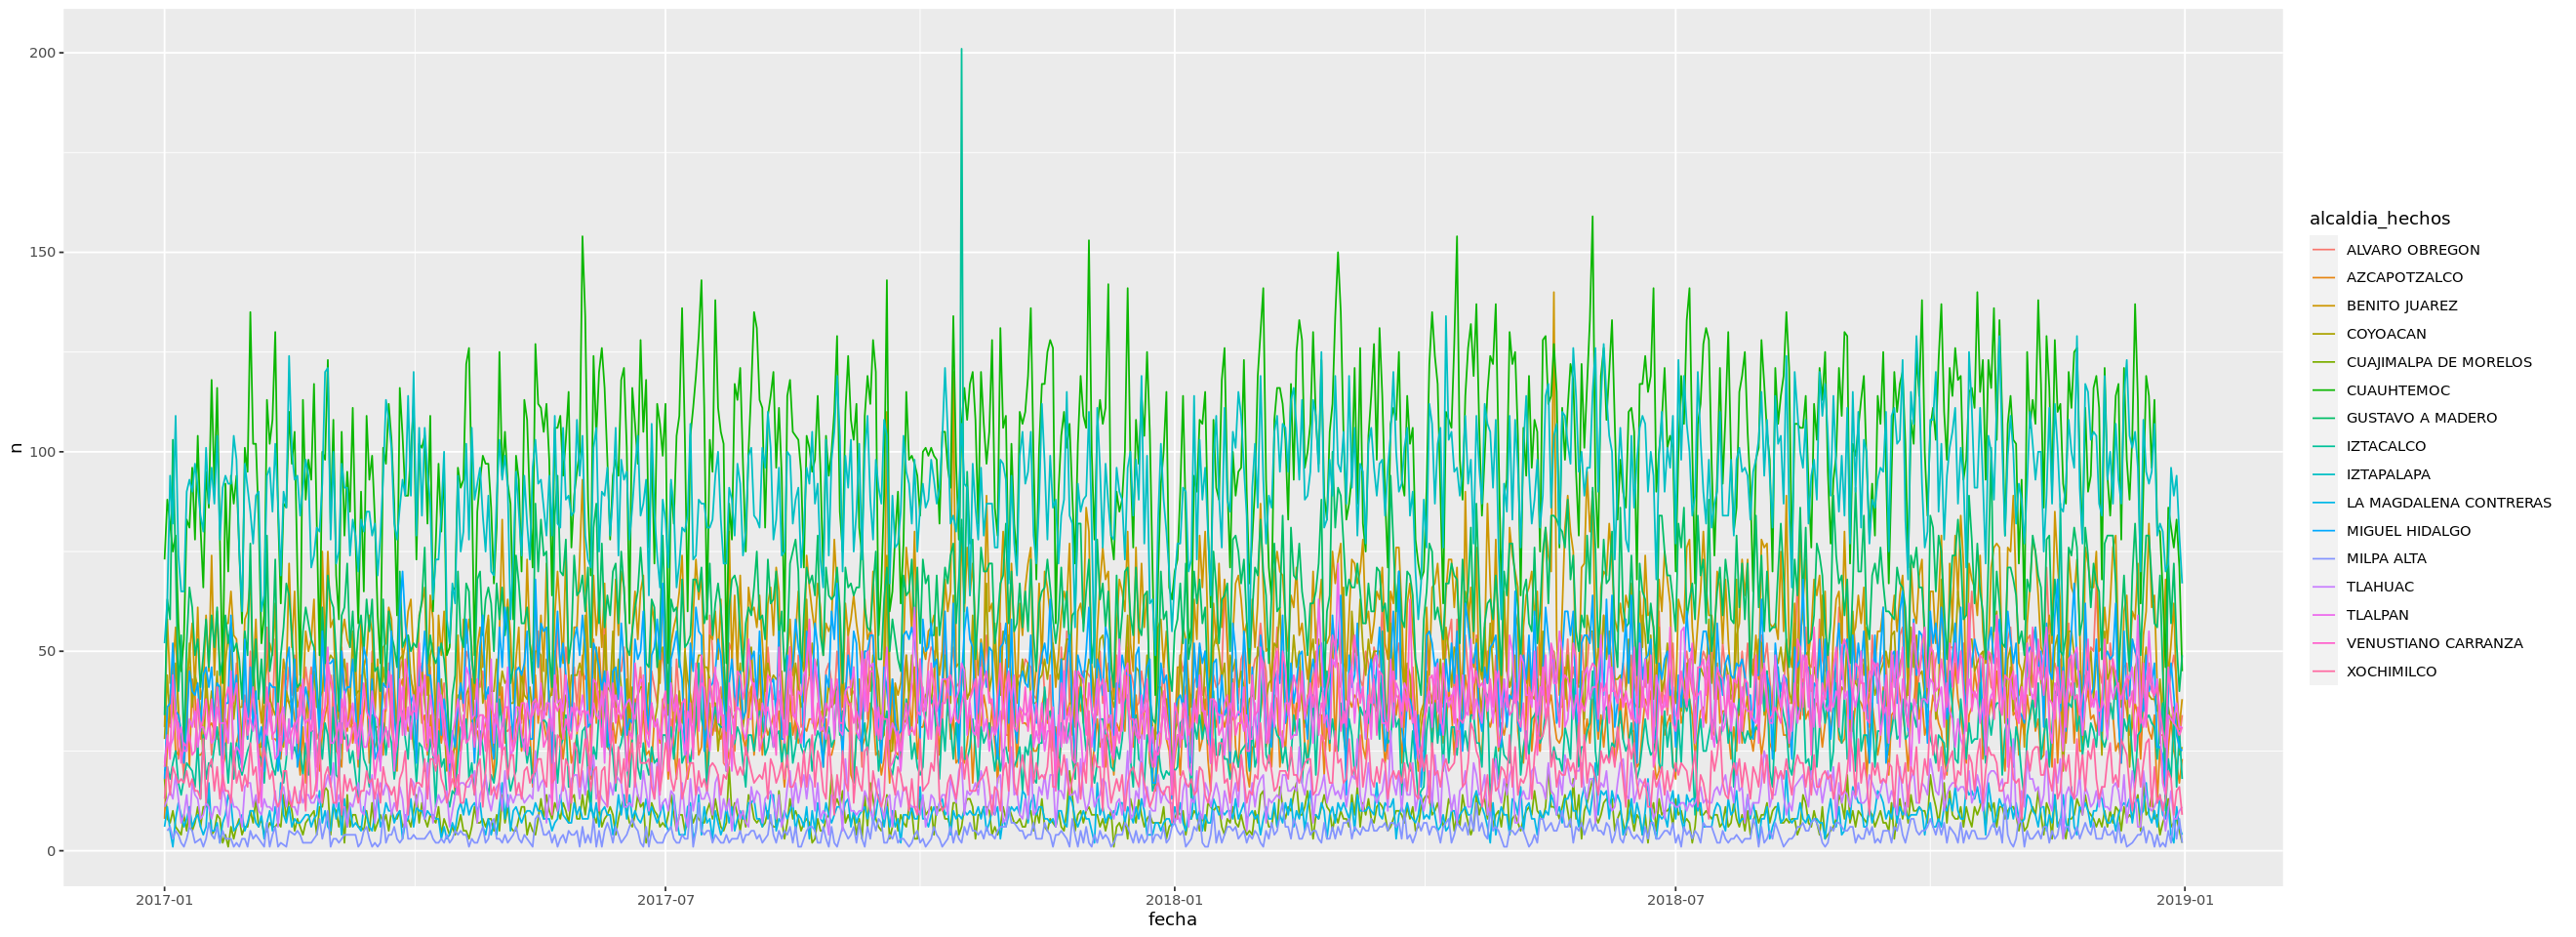

In [139]:
plot2 <- delitos_mun %>% 
ggplot(aes(x = fecha, y = n, color = alcaldia_hechos)) +
geom_line()

#ggplotly(plot2)
plot2

Para apreciar mejor cada una se las series, se muestran de manera desagregada cada una de las series de acuerdo a la alcaldía

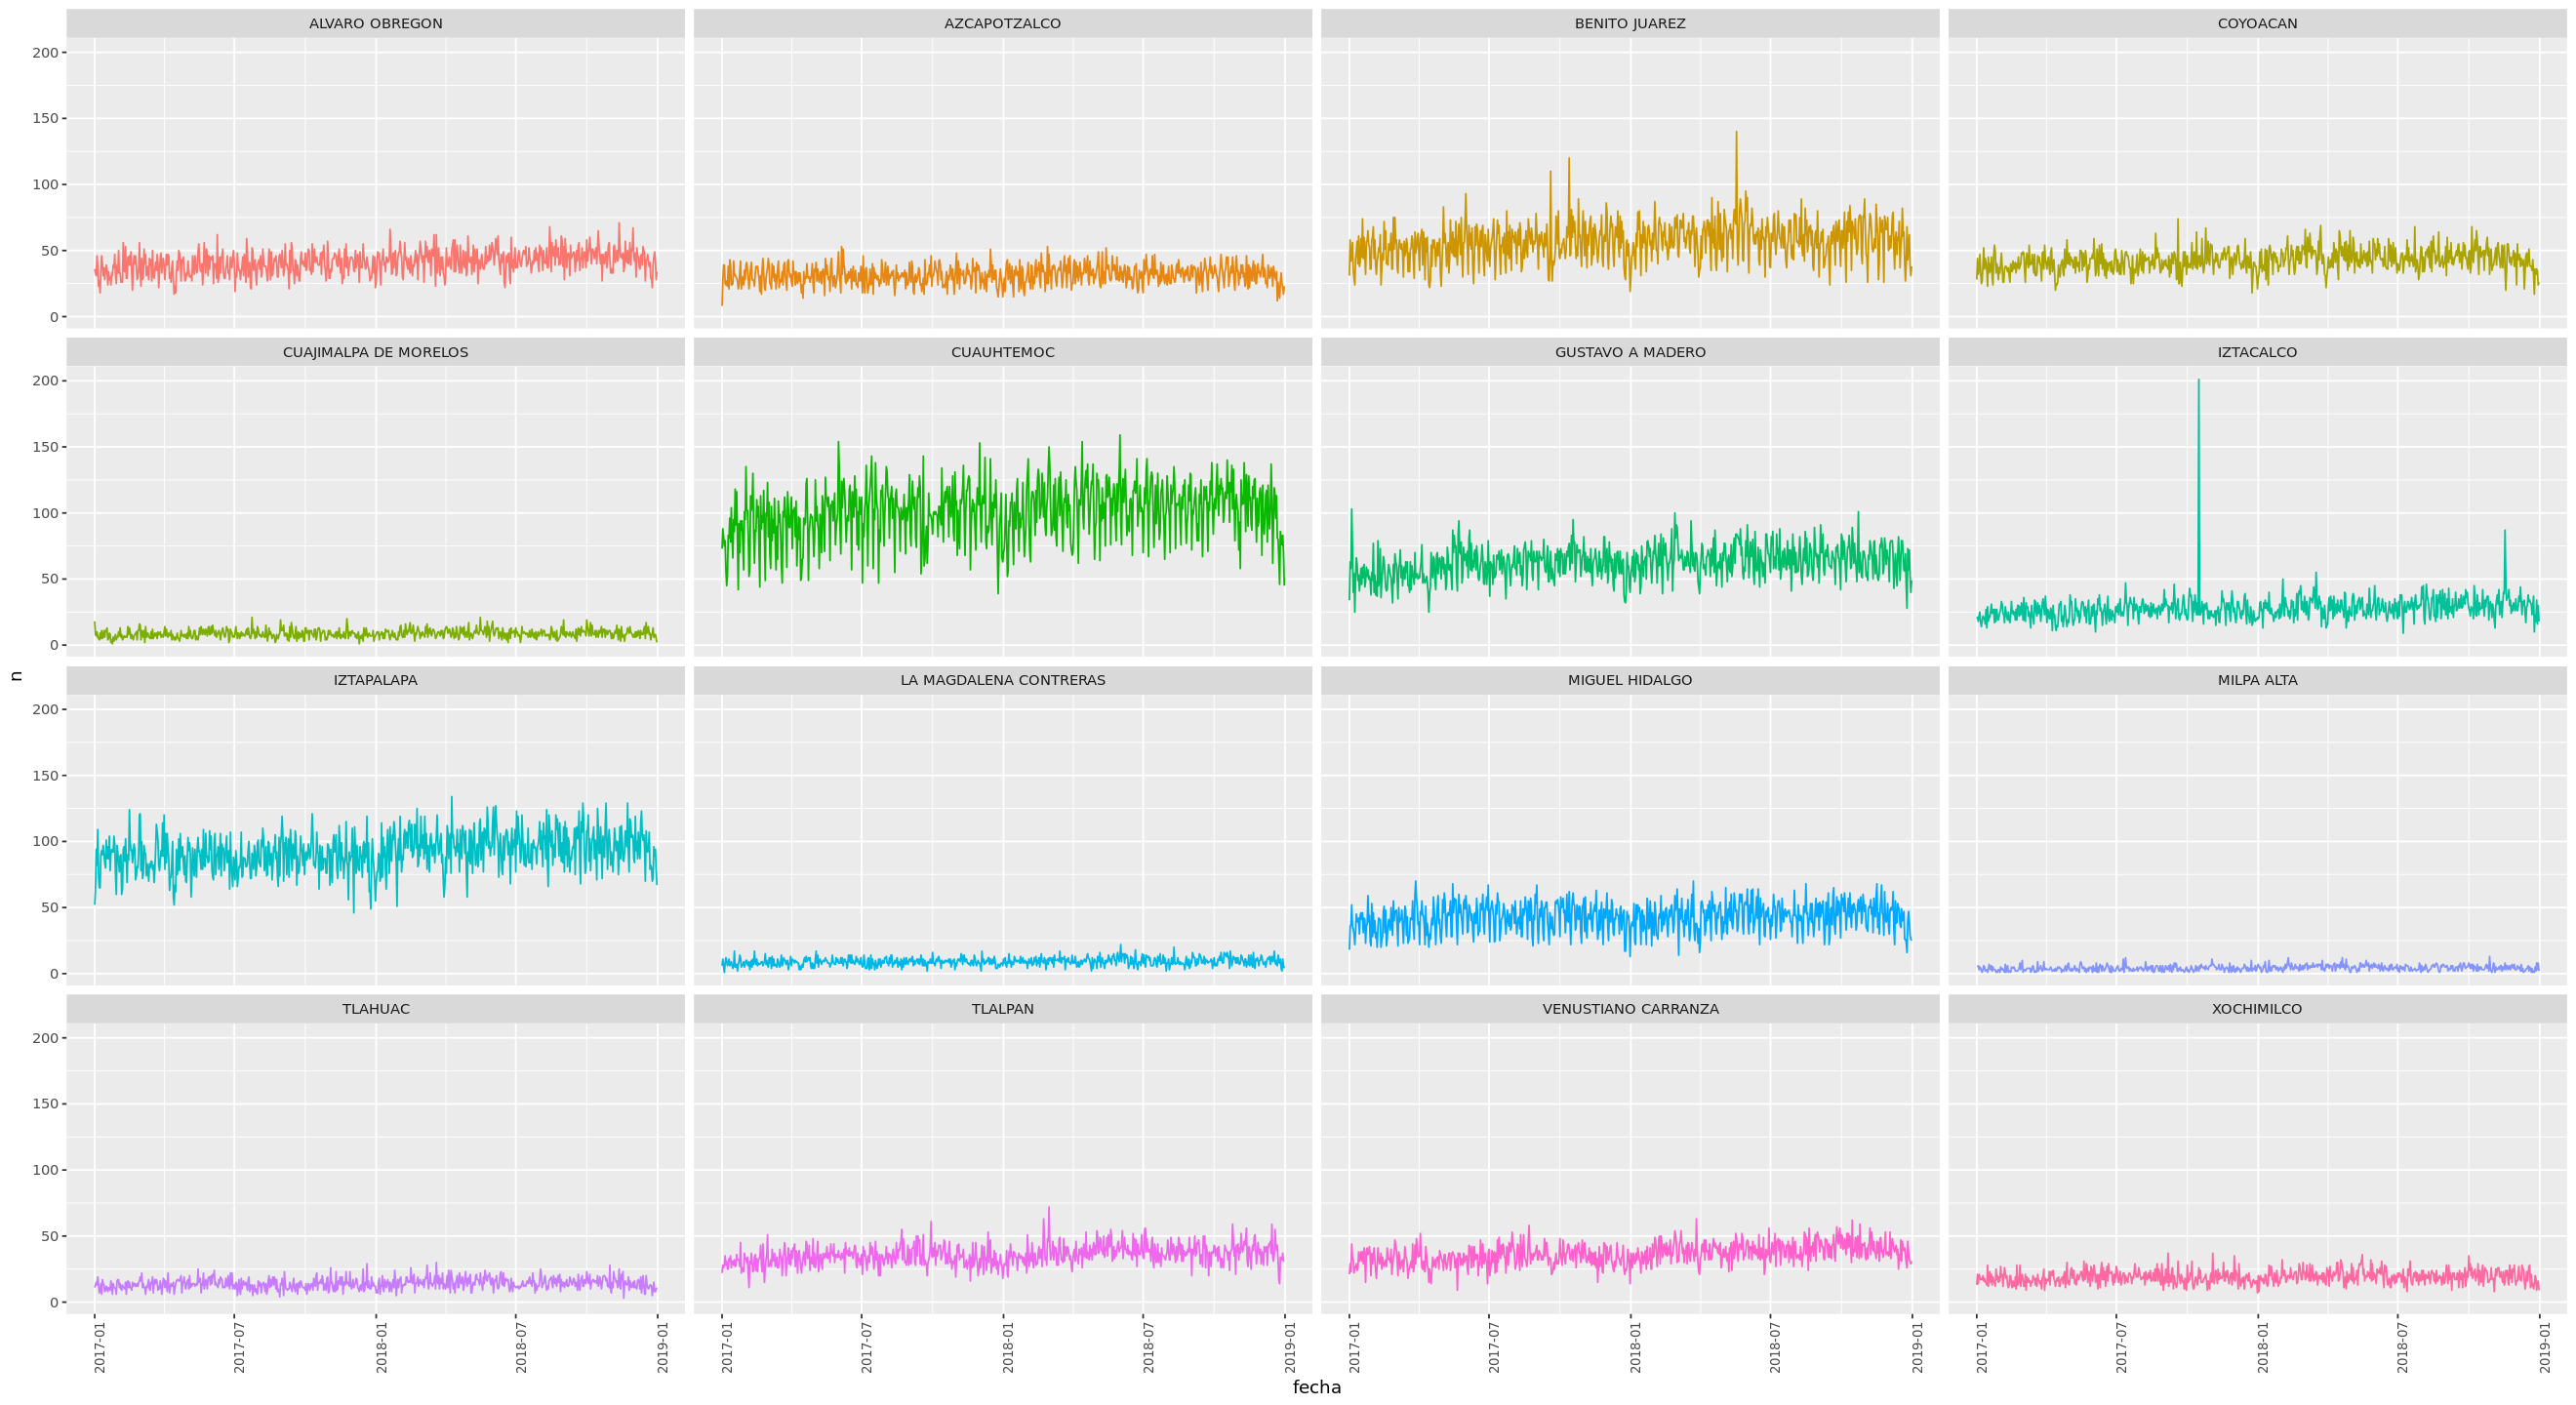

In [140]:
options(repr.plot.width=22, repr.plot.height=12)

plot3 <- delitos_mun %>% 
ggplot(aes(x = fecha, y = n, color = alcaldia_hechos)) +
geom_line() + facet_wrap(~alcaldia_hechos) +
theme(legend.position = "none", axis.text.x = element_text(angle = 90, hjust = 1, size = 8))

#ggplotly(plot3)
plot3

## Análisis de asociación (correlación)

In [131]:
pob <- read_csv("data/datos_pob.csv")
sample_n(pob,5)

Parsed with column specification:
cols(
  entidad = col_character(),
  cve_mun = col_character(),
  delegación = col_character(),
  Población = col_number(),
  Población_hombres = col_number(),
  Población_mujeres = col_number(),
  Edad_mediana_total = col_double(),
  Edad_mediana_hombres = col_double(),
  Edad_mediana_mujeres = col_double(),
  `Relación_hombres-mujeres` = col_double()
)



entidad          cve_mun delegación        Población Población_hombres
1 Distrito Federal 016     Miguel Hidalgo     372889   172667           
2 Distrito Federal 010     Álvaro Obregón     727034   346041           
3 Distrito Federal 011     Tláhuac            360265   175210           
4 Distrito Federal 013     Xochimilco         415007   205305           
5 Distrito Federal 005     Gustavo A. Madero 1185772   571233           
  Población_mujeres Edad_mediana_total Edad_mediana_hombres
1 200222            34                 33                  
2 380993            30                 29                  
3 185055            27                 26                  
4 209702            28                 28                  
5 614539            31                 30                  
  Edad_mediana_mujeres Relación_hombres-mujeres
1 35                   86.24                   
2 32                   90.83                   
3 28                   94.68                   
4 29                   97.90                   
5 33                   92.95

In [65]:
tot_delitos <- delitos_mun %>% group_by(alcaldia_hechos) %>% summarise(total_delitos = sum(n)) %>% as_tibble()

data_mun <- data.frame(alcaldia = pob$`delegación`, poblacion = pob$`Población`, delitos = tot_delitos$total_delitos)
head(data_mun, 10 )

`summarise()` ungrouping output (override with `.groups` argument)



alcaldia               poblacion delitos
1  Álvaro Obregón          727034   29909  
2  Azcapotzalco            414711   22932  
3  Benito Juárez           385439   41259  
4  Coyoacán                620416   30987  
5  Cuajimalpa de Morelos   186391    6336  
6  Cuauhtémoc              531831   73114  
7  Gustavo A. Madero      1185772   45491  
8  Iztacalco               384326   20210  
9  Iztapalapa             1815786   67083  
10 La Magdalena Contreras  239086    6645

In [104]:
cor(data_mun$poblacion, data_mun$delitos)

[1] 0.7019285

#### La correlación entre las variables es de 0.70

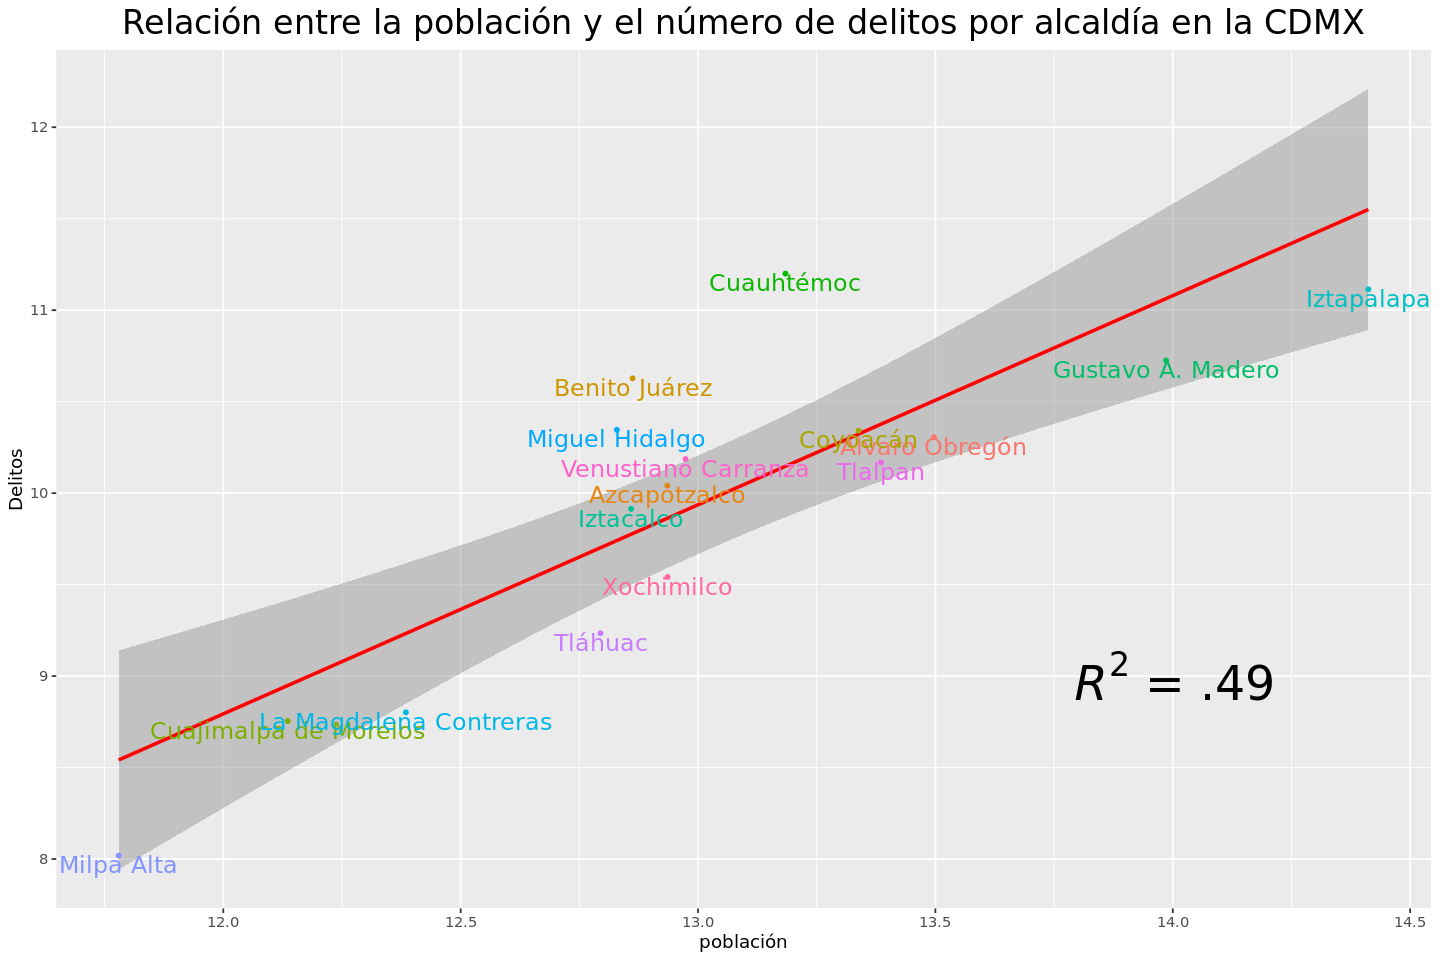

In [142]:
options(repr.plot.width=12, repr.plot.height=8)

plot3 <- data_mun %>% mutate(log_pob = log(poblacion), log_del = log(delitos)) %>% 
ggplot(aes(x = log_pob, y = log_del, label = alcaldia, size = 10, color = alcaldia)) +
geom_smooth(method='lm', formula= y~x, color = "red", alpha = 0.5, size = 1) +
geom_point(size = 1) + 
geom_text(aes(y = log_del-0.05, label = alcaldia),size = 5) + 
theme(legend.position = 'none', plot.title = element_text(size=20, hjust = 0.5)) +
ggtitle("Relación entre la población y el número de delitos por alcaldía en la CDMX") + xlab("población") + ylab("Delitos") + 
annotate("text", x = 14, y = 9, label = "paste(italic(R) ^ 2, \" = .49\")", parse = T, size = 10)

plot3

# Conclusiones

Los siguientes son los puntos más importantes del análisis realizado

* Existe una fuerte relación entre la cantidad poblacional y la cantidad de delitos
* Las alcaldías con mayor número de delitos son: Cuauhtémoc, Iztapalapa y Gustavo A. Madero
* Las alcaldías con menor número de delitos son: Milpa Alta, Cuajimalpa y La Magdalena Contreras
* Un análisis predictivo de los delitos en la Ciudad de México permite calcular la frecuencia diaria con un error aproxiumado promedio de 60 reportes
* De manera periódica, los domingos son los días con menor cantidad de delitos reportados
* Los días festivos baja significativamente el número de delitos reportados 